# Toy 8: Convex function

Represent engineering-like problems with trade-offs


In [35]:
import torch
from kan import create_dataset
from kan.custom import MultKAN
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

f = lambda x: x[:, [0]]**2 + torch.exp(x[:, [1]] * 2) / 4
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=100, device=device, normalize_label=True)

| train_loss: 3.55e-02 | test_loss: 3.33e-02 | reg: 4.10e+00 | : 100%|█| 20/20 [00:03<00:00,  5.38it
| train_loss: 6.58e-06 | test_loss: 6.72e-06 | reg: 7.26e+00 | : 100%|█| 50/50 [00:04<00:00, 10.11it


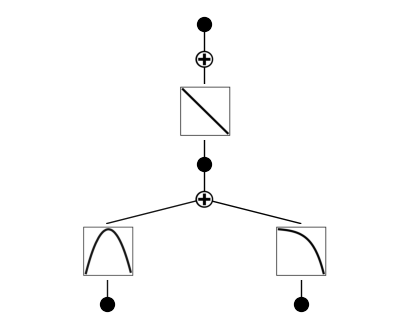

In [36]:
# grids_to_sym = [3, 5, 10, 20]
grids_to_sym = [20]

train_rmse_sym = []
test_rmse_sym = []

fit_kwargs = {
    'opt': "LBFGS",
    'steps': 20,
    'lamb': 0.01,
    'lamb_entropy': 0.1,
    'lamb_coef': 0.1,
    'lamb_coefdiff': 0.5,
}

model = MultKAN(width=[2,2,1], grid=3, k=3, seed=0, device=device)
model.fit(dataset, **fit_kwargs)
model = model.prune(edge_th=0.03, node_th=0.01)

for i in range(len(grids_to_sym)):
    model = model.refine(grids_to_sym[i])
    results = model.fit(dataset, opt='LBFGS', steps=50, stop_grid_update_step=20)
    train_rmse_sym.append(results['train_loss'][-1].item())
    test_rmse_sym.append(results['test_loss'][-1].item())

model.plot()

In [37]:
model.auto_symbolic()

r2 is 1.0000004768371582
fixing (0,0,0) with x^2, r2=1.0, c=2
r2 is 1.0000003576278687
fixing (0,1,0) with exp, r2=1.0, c=2
Best value at boundary.
r2 is 1.0000004768371582
fixing (1,0,0) with x, r2=1.0, c=1


| train_loss: 3.08e-04 | test_loss: 9.85e-01 | reg: 1.24e+00 | : 100%|█| 20/20 [00:02<00:00,  7.31it


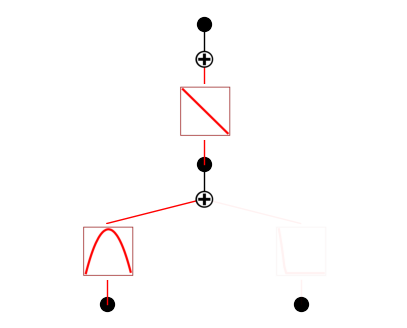

In [38]:
model.fit(dataset, **fit_kwargs)
model.plot()
plt.show()

In [39]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0], 4)

1.7867*x_1**2 + 0.4473*exp(1.9988*x_2) - 1.42

Text(0, 0.5, 'Attribution score')

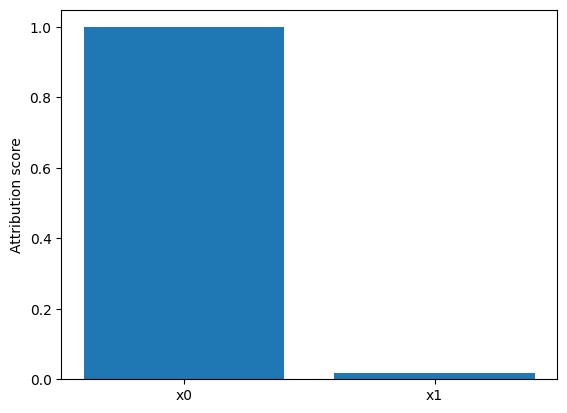

In [40]:
fig, ax = plt.subplots()
model.forward(dataset['train_input'])
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

in 0 -- out 0
Slope: [0.013379091396927834, 0.03036519605666399, 0.0395177761092782, 0.035927481949329376, 0.03227405995130539, 0.028872445225715637, 0.026643231511116028, 0.023165956139564514, 0.02002491056919098, 0.01816369593143463, 0.014108091592788696, 0.010555416345596313, -0.0028258562088012695, 0.0, -0.0029601752758026123, 0.0007874071598052979, 0.0024119019508361816, -0.002946138381958008, -0.012143269181251526, -0.015172228217124939, -0.01023353636264801, -0.003691732883453369]
Inflection point: 0.3969409465789795
in 1 -- out 0
Slope: [-0.002853803336620331, 0.0018235445022583008, 9.559094905853271e-06, 0.00931694358587265, 0.010495290160179138, 0.013097673654556274, 0.01349981501698494, 0.01647898554801941, 0.01915210299193859, 0.010289391502737999, 0.023252418264746666, 0.02692936174571514, 0.02942439541220665, 0.032052889466285706, 0.02785313129425049, 0.02490982413291931, 0.02812477946281433, 0.026466533541679382, 0.01820892095565796, 0.0007536709308624268, 0.007331222295

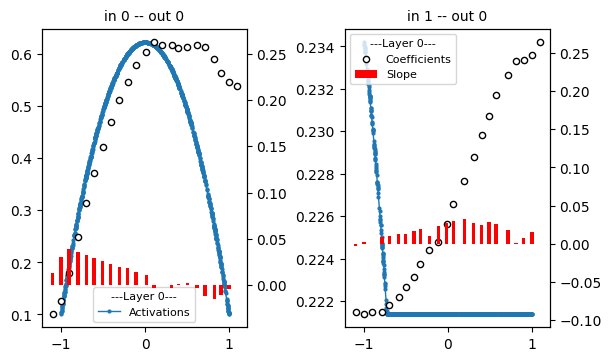

In [42]:
def find_index_sign_revert(data_list):
    """
    Finds the first index where the sign changes and persists for
    more than one element.

    Args:
        data_list (list): A list of numbers.

    Returns:
        int or None: The first index of a persistent sign change,
                     or None if no such change is found.
    """
    if len(data_list) < 3:
        # Not possible to have a persistent change
        return None

    signs = np.sign(data_list)

    for i in range(1, len(signs) - 1):
        if signs[i] != signs[i-1]:
            if signs[i+1] == signs[i]:
                return i

    return None

depth = len(model.act_fun)
layers_to_plot = [0]
inflection_points = []

for l in layers_to_plot:
    act = model.act_fun[l]
    ni, no = act.coef.shape[:2]
    coef = act.coef.tolist()
    inflection_points_per_layer = []

    fig, axs = plt.subplots(nrows=no, ncols=ni, squeeze=False,
                            figsize=(max(2.5*ni, 6), max(2.5*no, 3.5)),
                            constrained_layout=True)
    second_axs = np.zeros_like(axs)
    for i in range(ni):
        for j in range(no):
            ax = axs[j, i]
            # Gather pre- and post-activations and sort by input
            inputs = model.spline_preacts[l][:, j, i].cpu().detach().numpy()
            outputs = model.spline_postacts[l][:, j, i].cpu().detach().numpy()
            output_spline = model.spline_postsplines[l][:, j, i].cpu().detach().numpy() # without base function values
            coef_node = coef[i][j]
            num_knot = act.grid.shape[1]
            spline_radius = int((num_knot - len(coef_node)) / 2)
            bar_width = min(act.grid[i, 1:] - act.grid[i, :-1]) / 2

            rank = np.argsort(inputs)
            ax.plot(inputs[rank], outputs[rank], marker='o', ms=2, lw=1, label='Activations')
            # ax.plot(inputs[rank], output_spline[rank], marker='^', ms=1, lw=1, label='Splines Only')

            ax2 = ax.twinx()
            second_axs[j, i] = ax2
            ax2.scatter(act.grid[i, spline_radius:-spline_radius], coef_node,
                       s=20, color='white', edgecolor='k', label='Coefficients')
            slope = [x - y for x, y in zip(coef_node[1:], coef_node[:-1])]
            slope_2nd = [(x - y)*10 for x, y in zip(slope[1:], slope[:-1])]
            bars = ax2.bar(act.grid[i, spline_radius:-(spline_radius + 1)], slope,
                    width=bar_width, align='center', color='r', label='Slope')
            ax.set_title(f'in {i} -- out {j}', fontsize=10)

            inflection_val = act.grid[i, spline_radius + find_index_sign_revert(slope)]
            inflection_points_per_layer.append(inflection_val)

            print(f'in {i} -- out {j}')
            print(f'Slope: {slope}')
            print(f'Inflection point: {inflection_val}')
    axs[0, 0].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    second_axs[-1, -1].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    inflection_points.append(inflection_points_per_layer)

    plt.show()

[tensor(600), tensor(400)]


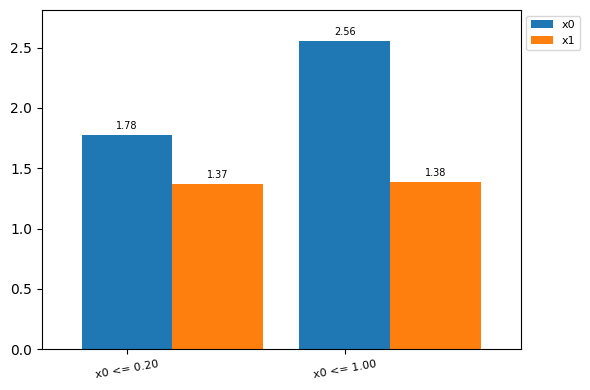

In [34]:
mask_idx = 0
mask_interval = [-1, inflection_points[0][mask_idx], 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'x{mask_idx} <= {ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
scores_interval_norm = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        x_std = torch.std(x_tensor_masked, dim=0).detach().cpu().numpy()
        model.forward(x_tensor_masked)

        score_masked = model.feature_score.detach().cpu().numpy()
        score_norm = score_masked / x_std
        scores_interval.append(score_masked)
        scores_interval_norm.append(score_norm)
    else:
        scores_interval.append(np.zeros(scores_tot.shape))
        scores_interval_norm.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval_norm])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval_norm], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()